In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re, string
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
file_path = "D:/Sem6/COMP 262 - NLP and Recommender Systems/Project/AMAZON_FASHION.json"

reviews = []
with open(file_path, "r") as file:
    for line in file:
        reviews.append(json.loads(line))


In [3]:
df = pd.DataFrame.from_dict(reviews)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883636 entries, 0 to 883635
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         883636 non-null  float64
 1   verified        883636 non-null  bool   
 2   reviewTime      883636 non-null  object 
 3   reviewerID      883636 non-null  object 
 4   asin            883636 non-null  object 
 5   reviewerName    883544 non-null  object 
 6   reviewText      882403 non-null  object 
 7   summary         883103 non-null  object 
 8   unixReviewTime  883636 non-null  int64  
 9   vote            79900 non-null   object 
 10  style           304569 non-null  object 
 11  image           28807 non-null   object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 75.0+ MB


In [4]:
df.describe()

,overall,unixReviewTime
count,883636.00000,8.836360e+05
mean,3.90694,1.456751e+09
std,1.41828,4.430691e+07
min,1.00000,1.036973e+09
25%,3.00000,1.434240e+09
50%,5.00000,1.462234e+09
75%,5.00000,1.484266e+09
max,5.00000,1.538352e+09


In [5]:
df.isnull().sum()

overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          92
reviewText          1233
summary              533
unixReviewTime         0
vote              803736
style             579067
image             854829
dtype: int64

In [6]:
review_count = len(df)

In [7]:
average_rating = df['overall'].mean()
average_rating

3.9069401880412298

In [8]:
product_review_counts = df['asin'].value_counts()
product_review_counts

asin
B000V0IBDM    4384
B000KPIHQ4    4375
B00I0VHS10    3889
B00RLSCLJM    3638
B000PHANNM    2572
              ... 
B00VQHSOE0       1
B00VQH61O0       1
B00VQGEHII       1
B00VQGZT76       1
B01HJG5NMW       1
Name: count, Length: 186189, dtype: int64

In [9]:
reviews_per_product = df.groupby('asin')['reviewerID'].count()
reviews_per_product

asin
0764443682    1
1291691480    1
1940280001    1
1940735033    7
1940967805    1
             ..
B01HJGXL4O    1
B01HJGZVYW    1
B01HJH7JY6    1
B01HJHF97K    1
B01HJHTH5U    8
Name: reviewerID, Length: 186189, dtype: int64

In [10]:
reviews_per_user = df.groupby('reviewerID')['asin'].count()
reviews_per_user

reviewerID
A0007604Q2582KFW7N4B    1
A0010606488RW7ZH6EP7    1
A001152055E9KVRHH96L    1
A00181966XZUX7KEGYLH    1
A00205926S885DTOYMX6    1
                       ..
AZZYFFDBSSBJC           1
AZZYVTX23JWKM           1
AZZYVURSF9KK6           1
AZZZMCJO078D2           1
AZZZU2YUCMUUW           1
Name: asin, Length: 749233, dtype: int64

In [11]:
print('-=-=-=-=-=-=-=-Check for null value-=-=-=-=-=-=-=-')
print(df.isnull().sum())


-=-=-=-=-=-=-=-Check for null value-=-=-=-=-=-=-=-
overall                0
verified               0
reviewTime             0
reviewerID             0
asin                   0
reviewerName          92
reviewText          1233
summary              533
unixReviewTime         0
vote              803736
style             579067
image             854829
dtype: int64


In [12]:
# Drop rows where 'reviewText' columns has NaN values
df = df.dropna(subset=['reviewText'])

In [13]:
# Identify outliers
df['review_length'] = df['reviewText'].apply(lambda x: len(x))
review_length = df['review_length']
review_counts = range(1, len(review_length) + 1)


In [14]:

# Identify the outlier outside 25-75% percentile
review_length_stats = review_length.describe()
review_length_outliers = df[review_length > review_length_stats['75%'] + 1.5 * (review_length_stats['75%'] - review_length_stats['25%'])]

Q1 = review_length_stats['25%']  # 25th percentile
Q3 = review_length_stats['75%']  # 75th percentile
IQR = Q3 - Q1

# Calculate the upper boundary for outliers
upper_bound = Q3 + 1.5 * IQR

# Select rows where review_length is greater than the upper_bound
review_length_outliers = df[df['review_length'] > upper_bound]

review_count = len(df)
product_review_percent = product_review_counts / review_count * 100
less_than_01_percent = product_review_percent < 0.1
index_of_reviews = df[df['asin'].isin(product_review_counts[less_than_01_percent].index)].index
index_of_reviews


Index([     0,      1,      2,      3,      4,      5,      6,      7,      8,
            9,
       ...
       883626, 883627, 883628, 883629, 883630, 883631, 883632, 883633, 883634,
       883635],
      dtype='int64', length=817133)

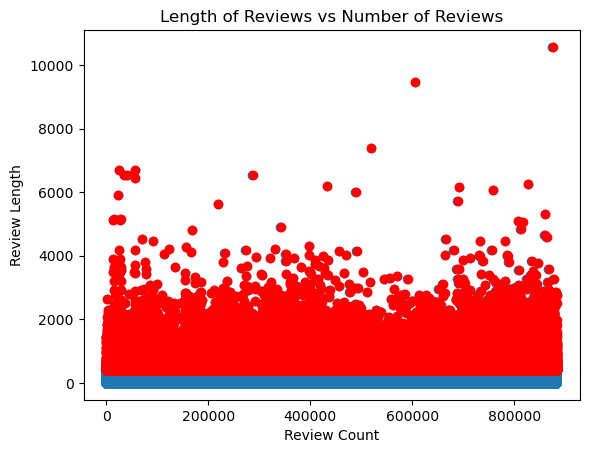

In [15]:
# Visualize review lengths with the outliers visible
plt.scatter(review_counts, review_length)
plt.scatter(review_length_outliers.index, review_length_outliers['review_length'], color='red')
plt.xlabel('Review Count')
plt.ylabel('Review Length')
plt.title('Length of Reviews vs Number of Reviews')
plt.show()

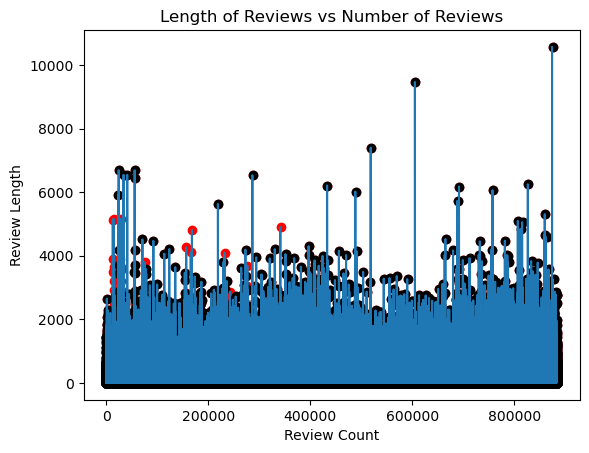

In [16]:

plt.plot(review_counts, review_length)
plt.scatter(review_length_outliers.index, review_length_outliers['review_length'], color='red')
plt.scatter(index_of_reviews, df.loc[index_of_reviews, 'review_length'], color='black')
plt.xlabel('Review Count')
plt.ylabel('Review Length')
plt.title('Length of Reviews vs Number of Reviews')
plt.show()

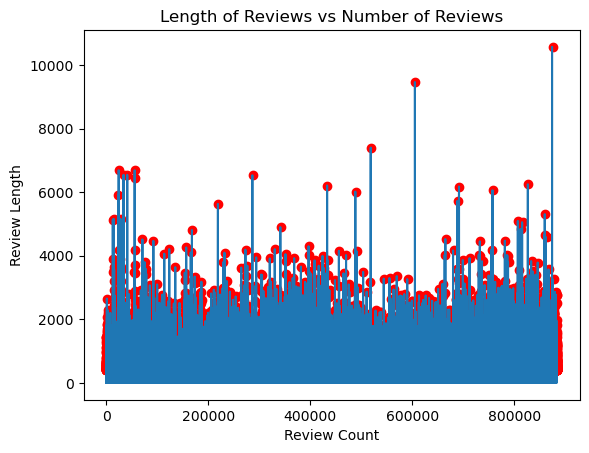

In [17]:

plt.plot(review_counts, review_length)
plt.scatter(review_length_outliers.index, review_length_outliers['review_length'], color='red')
plt.xlabel('Review Count')
plt.ylabel('Review Length')
plt.title('Length of Reviews vs Number of Reviews') 
plt.show()


In [18]:

def show_wordcloud(df):
    corpus=[]
    stem = PorterStemmer()
    lem = WordNetLemmatizer()
    for review in df:
        review = str(review)
        words = [w for w in word_tokenize(review) if (w not in stopwords)]

        words = [lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

# Calculate z score
def calculate_z_scores(data):
    return (data - np.mean(data)) / np.std(data)

# Filter out data with z-score more than threshold 3
def remove_outliers_zscore(data, threshold=3):
    z_scores = calculate_z_scores(data)
    filtered_data = data[abs(z_scores) < threshold]
    return filtered_data

# Box plot
def outliers_boxplot(data):
    fig, ax = plt.subplots()
    ax.boxplot(data, showfliers=True)
    # Set showfliers=True to show outliers
    plt.title('Box Plot')
    plt.show()

# Text preprocessing
def preprocess_text(text):
    # Convert the text to lower case
    text = text.lower()
      
    text = text.translate(str.maketrans('','', string.punctuation))
    text = re.sub(r'\s+\w{1,3}[\.,;!?]?$', '', text)
    text = text.strip()

    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stopwords]
    
    # perform stemming and lemmatization 
    lemmatizer = WordNetLemmatizer() 
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens] 
    
    # Convert tokens to string
    token_str = ' '.join(lemmatized_tokens)
    
    return token_str


# Function to plot a confusion matrix in a beautiful way
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, cbar=False, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()


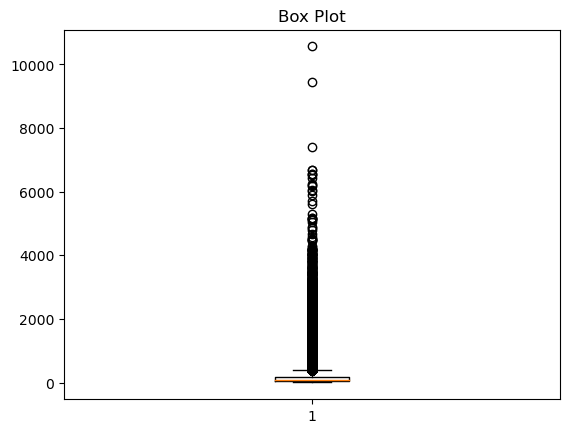

In [19]:
remove_outliers_zscore(df['review_length'])
outliers_boxplot(df['review_length'])

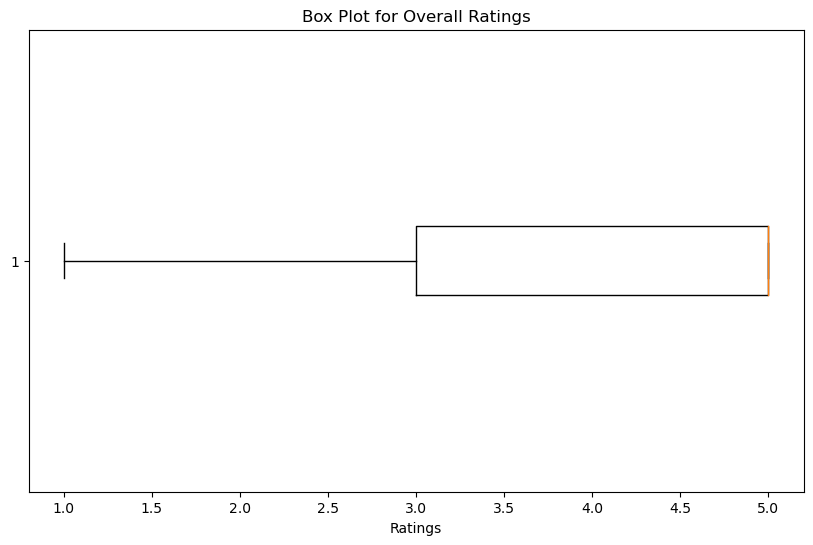

In [20]:
# Box plot for the 'overall' column
plt.figure(figsize=(10, 6))
plt.boxplot(df['overall'], vert=False)
plt.title('Box Plot for Overall Ratings')
plt.xlabel('Ratings')
plt.show()


In [21]:
Q1 = df['overall'].quantile(0.25)
Q3 = df['overall'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df[(df['overall'] < lower_bound) | (df['overall'] > upper_bound)]
print("Outliers based on the 'overall' column:")
print(outliers)

Outliers based on the 'overall' column:
Empty DataFrame
Columns: [overall, verified, reviewTime, reviewerID, asin, reviewerName, reviewText, summary, unixReviewTime, vote, style, image, review_length]
Index: []


In [22]:
# Display word cloud
# show_wordcloud(df['reviewText'])

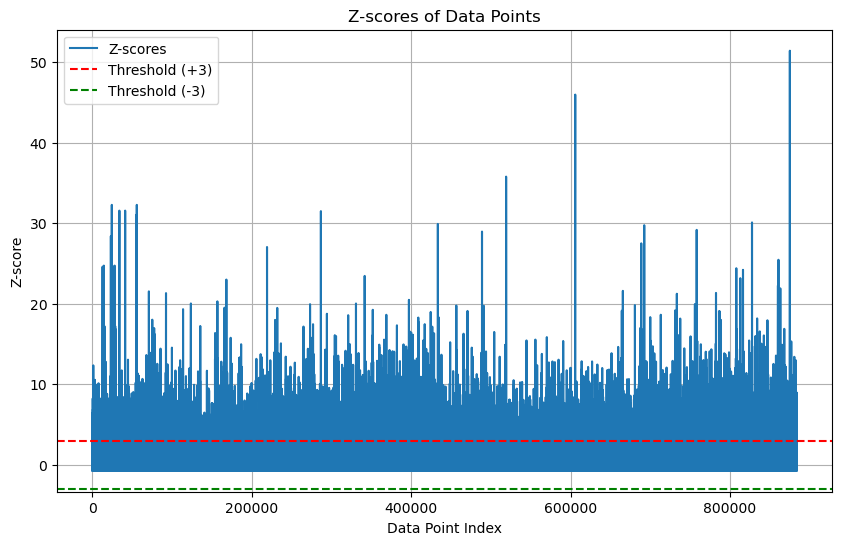

In [23]:
# Generate a line graph for with the outliers
z_scores = calculate_z_scores(df['review_length'])

plt.figure(figsize=(10, 6))
plt.plot(z_scores, label='Z-scores')
plt.axhline(y=3, color='r', linestyle='--', label='Threshold (+3)')
plt.axhline(y=-3, color='g', linestyle='--', label='Threshold (-3)')
plt.title('Z-scores of Data Points')
plt.xlabel('Data Point Index')
plt.ylabel('Z-score')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Remove all duplicates
df = df.drop_duplicates(subset=['reviewerID', 'asin', 'reviewText'], keep=False)
df.shape
# Remove the outliers
df = df[~df.index.isin(review_length_outliers.index)]
df.shape


(804193, 13)

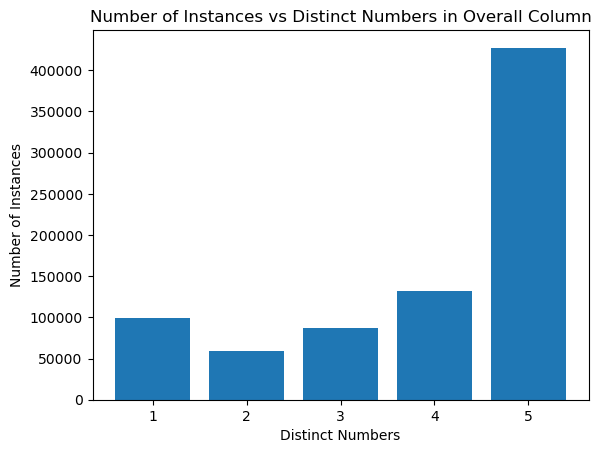

In [25]:

overall_counts = df['overall'].value_counts()
distinct_numbers = overall_counts.index

plt.bar(distinct_numbers, overall_counts)
plt.xlabel('Distinct Numbers')
plt.ylabel('Number of Instances')
plt.title('Number of Instances vs Distinct Numbers in Overall Column')
plt.show()


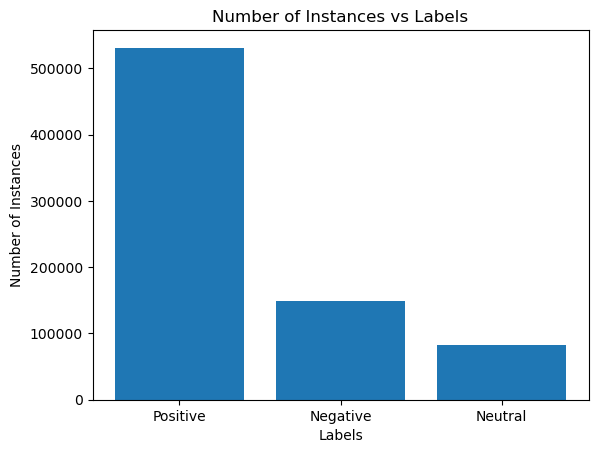

In [26]:
# Label your data based on the value of “rating of the product”
df['label'] = df['overall'].apply(lambda x: 'Positive' if x in [4, 5] else 'Neutral' if x == 3 else 'Negative')


# Remove all the unverified reviews
df = df[df['verified'] == True]
df.shape

label_counts = df['label'].value_counts()
distinct_labels = label_counts.index

plt.bar(distinct_labels, label_counts)
plt.xlabel('Labels')
plt.ylabel('Number of Instances')
plt.title('Number of Instances vs Labels')
plt.show()


In [27]:
# =============================================================================
# Feature extraction
# =============================================================================

df.columns

df.info()

df.isnull().sum()

df = df.drop(columns = ['vote', 'style', 'image','reviewTime','reviewerID','asin','reviewerName','unixReviewTime'])

df.info()

df.isnull().sum()

df = df.drop(columns = ['overall','verified','review_length'])

df.info()

df.isnull().sum()

df['summary'].head(5)

columns_to_consider = ['reviewText', 'label']


# =============================================================================
# =============================================================================


<class 'pandas.core.frame.DataFrame'>
Index: 763324 entries, 0 to 883635
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         763324 non-null  float64
 1   verified        763324 non-null  bool   
 2   reviewTime      763324 non-null  object 
 3   reviewerID      763324 non-null  object 
 4   asin            763324 non-null  object 
 5   reviewerName    763253 non-null  object 
 6   reviewText      763324 non-null  object 
 7   summary         762861 non-null  object 
 8   unixReviewTime  763324 non-null  int64  
 9   vote            54864 non-null   object 
 10  style           260718 non-null  object 
 11  image           18447 non-null   object 
 12  review_length   763324 non-null  int64  
 13  label           763324 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(10)
memory usage: 82.3+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 763324 entries, 0 to 883635
Data columns

In [28]:
# Keep important columns
df_filtered = pd.DataFrame(df, columns=columns_to_consider)


df_filtered.shape

from nltk.corpus import stopwords
stop = stopwords.words('english')
df_filtered['reviewText'] = df_filtered['reviewText'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

stopwords = set(stopwords.words('english'))

df_filtered = df_filtered.drop_duplicates(subset=['reviewText'])

df_filtered.shape


(657920, 2)

In [29]:

df_filtered['reviewText'] = df_filtered['reviewText'].apply(preprocess_text)

In [30]:
df_filtered['label'].value_counts()

from sklearn.utils import resample

# Balance the dataset
df_balanced = pd.concat([
    resample(df_filtered[df_filtered['label'] == 'Positive'], n_samples=667, random_state=17),
    resample(df_filtered[df_filtered['label'] == 'Neutral'], n_samples=667, random_state=17),
    resample(df_filtered[df_filtered['label'] == 'Negative'], n_samples=666, random_state=17)
])

df_balanced.reset_index(drop=True, inplace=True)

In [31]:
subset_sample = df_filtered.sample(n=2000, random_state=17)

subset_sample.reset_index(drop=True, inplace=True)

## with Word2vec

In [32]:
from gensim.models import Word2Vec

In [35]:
# Tokenize the reviews
subset_sample['tokenized_reviews'] = subset_sample['reviewText'].apply(lambda x: x.split())

# Train a Word2Vec model
w2v_model = Word2Vec(subset_sample['tokenized_reviews'], min_count=1)

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.wv.key_to_index]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    else:
        return np.mean(word2vec_model.wv[doc], axis=0)

# Now we can use the function to create document vectors
X = subset_sample['tokenized_reviews'].apply(lambda x: document_vector(w2v_model, x))


X = np.stack(X)
X = np.nan_to_num(X)
y = subset_sample['label']

In [34]:
X.shape, y.shape

((2000, 100), (2000,))

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import joblib


In [37]:
from sklearn.model_selection import StratifiedShuffleSplit
# Create StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=17)

# Split the data into train and test sets using stratified shuffle split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


In [38]:
lr = LogisticRegression(random_state=17)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", lr_accuracy)



Logistic Regression Accuracy: 0.685


In [39]:
svm = SVC(random_state=17)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("Support Vector Machine Accuracy:", svm_accuracy)


Support Vector Machine Accuracy: 0.685


In [ ]:

nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)



In [41]:
gb = GradientBoostingClassifier(random_state=17)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print("Gradient Boosting Accuracy:", gb_accuracy)


Gradient Boosting Accuracy: 0.7


In [42]:

mlp = MLPClassifier(random_state=17)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_pred)
print("Multilayer Perceptron Accuracy:", mlp_accuracy)

Multilayer Perceptron Accuracy: 0.685


c:\Users\gitan\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## With - tfidf vectorizer

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(subset_sample['reviewText'])

X.shape

y = subset_sample['label']


In [48]:
from sklearn.model_selection import StratifiedShuffleSplit
# Create StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=17)

# Split the data into train and test sets using stratified shuffle split
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


In [58]:
X_train[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [49]:
lr = LogisticRegression(random_state=17)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print("Logistic Regression Accuracy:", lr_accuracy)




Logistic Regression Accuracy: 0.775


In [50]:
svm = SVC(random_state=17)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("Support Vector Machine Accuracy:", svm_accuracy)



Support Vector Machine Accuracy: 0.745


In [51]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
print("Naive Bayes Accuracy:", nb_accuracy)


Naive Bayes Accuracy: 0.705


In [52]:

gb = GradientBoostingClassifier(random_state=17)
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print("Gradient Boosting Accuracy:", gb_accuracy)



Gradient Boosting Accuracy: 0.76


In [53]:
mlp = MLPClassifier(random_state=17)
mlp.fit(X_train, y_train)
mlp_pred = mlp.predict(X_test)
mlp_accuracy = accuracy_score(y_test, mlp_pred)
print("Multilayer Perceptron Accuracy:", mlp_accuracy)

Multilayer Perceptron Accuracy: 0.745


## Saving the Models 

In [59]:



# joblib.dump(lr, 'pickle files/logistic_regression_model.pkl')

# joblib.dump(svm, 'pickle files/support_vector_machine_model.pkl')

# joblib.dump(nb, 'pickle files/naive_bayes_model.pkl')

# joblib.dump(gb, 'pickle files/gradient_boosting_model.pkl')

# joblib.dump(mlp, 'pickle files/multilayer_perceptron_model.pkl')

# joblib.dump(vectorizer, 'pickle files/tfidf_vectorizer.pkl')



## Creating balanced dataset for apple to apple comparison

In [ ]:
# df_new = subset_sample

# df_comparison = pd.concat([
#     resample(df_new[df_new['label'] == 'Positive'], n_samples=334, random_state=17),
#     resample(df_new[df_new['label'] == 'Neutral'], n_samples=333, random_state=17),
#     resample(df_new[df_new['label'] == 'Negative'], n_samples=333, random_state=17)
# ])

# df_comparison.reset_index(drop=True, inplace=True)

# df_comparison['label'].value_counts()

# df_comparison.to_csv('df_comparison.csv', index=False)
